In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import datetime, timedelta
import xlrd

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
dataset = pd.read_csv("C:/Users/mandar/Downloads/data.csv")

In [5]:
# Performance Metrics

In [6]:
# We would like to determine the effectiveness of new trial layouts in trial stores 77, 86 and 88 for the trial period of February 2019 to April 2019. We would like to measure the performance of these stores on three metrics:Total sales revenue, Total number of customers, Average number of transactions per customer.
# We will calculate these by month over the period of interest.

In [7]:
# Orderr by Date
dataset = dataset.sort_values(by=['DATE'])

In [8]:
# Convert Date Column to Datetime Type
dataset['DATE'] = pd.to_datetime(dataset['DATE'])

In [9]:
# Create Year-Month Column
dataset['YEAR_MONTH'] = pd.to_datetime(dataset['DATE']).dt.to_period('M')

In [10]:
dataset.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,BRAND,PACK_SIZE,YEAR_MONTH
200063,2018-07-01,152,152040,150459,25,Pringles SourCream Onion 134g,2,7.4,YOUNG FAMILIES,Mainstream,Pringles,134,2018-07
60194,2018-07-01,128,128215,132006,29,French Fries Potato Chips 175g,2,6.0,OLDER FAMILIES,Mainstream,French Fries,175,2018-07
214319,2018-07-01,230,230210,233375,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,YOUNG FAMILIES,Premium,Tyrrells,165,2018-07
88949,2018-07-01,181,181080,182897,112,Tyrrells Crisps Ched & Chives 165g,2,8.4,OLDER SINGLES/COUPLES,Budget,Tyrrells,165,2018-07
39979,2018-07-01,83,83189,83183,2,Cobs Popd Sour Crm &Chives Chips 110g,2,7.6,OLDER FAMILIES,Budget,Cobs,110,2018-07


In [11]:
dataset.tail()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,BRAND,PACK_SIZE,YEAR_MONTH
37616,2019-06-30,48,48046,43327,61,Smiths Crinkle Cut Chips Chicken 170g,2,5.8,OLDER FAMILIES,Budget,Smiths,170,2019-06
225061,2019-06-30,95,95300,95463,23,Cheezels Cheese 330g,2,11.4,YOUNG SINGLES/COUPLES,Mainstream,Cheezels,330,2019-06
148988,2019-06-30,62,62042,58031,98,NCC Sour Cream & Garden Chives 175g,2,6.0,RETIREES,Mainstream,Natural Chip Co,175,2019-06
246480,2019-06-30,100,100178,99578,2,Cobs Popd Sour Crm &Chives Chips 110g,2,7.6,YOUNG SINGLES/COUPLES,Premium,Cobs,110,2019-06
66677,2019-06-30,144,144002,143909,37,Smiths Thinly Swt Chli&S/Cream175G,2,6.0,OLDER FAMILIES,Premium,Smiths,175,2019-06


In [12]:
def total_sales(store_data):
    '''
    Input: Takes a dataframe store_data which is filtered on a particular store number
    Returns: A vector containing the total sales by month for that store
    '''
    sales = [] 
    months = store_data.YEAR_MONTH.unique()
    for month in months:
        month_data = store_data[store_data.YEAR_MONTH == month]
        revenue = round(month_data.TOT_SALES.sum(), 2)
        sales.append(revenue)
    return pd.Series(sales)

def total_customers(store_data):
    '''
    Input: Takes a dataframe store_data which is filtered on a particular store number
    Returns: A vector containing the number of unique customers by month for that store
    '''
    customers = [] 
    months = store_data.YEAR_MONTH.unique()
    for month in months:
        month_data = store_data[store_data.YEAR_MONTH == month]
        num_cust = len(month_data.LYLTY_CARD_NBR.unique())
        customers.append(num_cust)
    return pd.Series(customers)

def avg_transactions(store_data):
    '''
    Input: Takes a dataframe store_data which is filtered on a particular store number
    Returns: A vector containing the average number of transactions per customer by month
             for that store calculated by (number of transactions / number of unique customers)
    '''
    transactions = [] 
    months = store_data.YEAR_MONTH.unique()
    for month in months:
        month_data = store_data[store_data.YEAR_MONTH == month]
        avg_trans = len(month_data) / len(month_data.LYLTY_CARD_NBR.unique())
        transactions.append(round(avg_trans, 2))
    return pd.Series(transactions)

In [13]:
# Choosing Control Stores

#In order to determine if the trial stores perform better on the metrics we have defined, we will assign a control store (in which there is no new layout) to each trial store to make the comparison.
#When choosing a corresponding control store for each trial store we want to choose a control store that is similar to the trial store in terms of performance in the pre-trial period of July 2018 to January 2019. Then, we can compare if and how performance diverges during the trial period. Since our dataset is sampled from the period July 2018 to June 2019, this should not be a problem.

In [14]:
# We split the data into the pre-trial period (July 2018 to January 2019) and trial period (February 2019 to April 2019). Then for each period we separate out the three trial stores from the potential controls.
# In order to form optimal trial-control pairings for each trial store, we make pairwise comparisons between each trial store and each potential control store to determine similarity using the monthly metric functions defined above. Over the pre-trial period we will determine the correlation between pairs of stores on the metrics: Total sales revenue, Total number of customers

In [15]:
#We calculate both these metrics by month for each (potential control, trial) pair.
#Then for each trial store, we will select the control store that has the highest correlation, averaged over the 2 correlation coefficients calculated, giving us 3 optimal trial-control pairs.

In [16]:
# Set Date Column as Index
dataset = dataset.set_index(['DATE'])

In [17]:
# Splitting the dataset into pre-trial and trial periods
pre_trial = dataset.loc['2018-07-01' : '2019-01-31']
trial = dataset.loc['2019-02-01' : '2019-04-30']

In [18]:
# Separate Control Candidates from Trial Stores
pretrial_candidates = pre_trial.loc[(pre_trial['STORE_NBR'] != 77) & (pre_trial['STORE_NBR'] != 86) & (pre_trial['STORE_NBR'] != 88)]

pre_store_nums = np.sort(pretrial_candidates.STORE_NBR.unique())

pretrial_77 = pre_trial.loc[pre_trial['STORE_NBR'] == 77]
pretrial_86 = pre_trial.loc[pre_trial['STORE_NBR'] == 86]
pretrial_88 = pre_trial.loc[pre_trial['STORE_NBR'] == 88]

print(len(pretrial_77))
print(len(pretrial_86))
print(len(pretrial_88))

305
845
1028


In [19]:
trial_candidates = trial.loc[(trial['STORE_NBR'] != 77) & (trial['STORE_NBR'] != 86) & (trial['STORE_NBR'] != 88)]

trial_store_nums = np.sort(trial_candidates.STORE_NBR.unique())

trial_77 = trial.loc[trial['STORE_NBR'] == 77]
trial_86 = trial.loc[trial['STORE_NBR'] == 86]
trial_88 = trial.loc[trial['STORE_NBR'] == 88]

print(len(trial_77))
print(len(trial_86))
print(len(trial_88))

142
387
470


In [20]:
# We check to make sure that we have the same set of stores in the pretrial and trial periods and find that in the pretrial period stores 11, 31, 76 and 85 appear but in the trial period they don't. 
# We can filter these out as candidates as we need stores for which we have data across both periods.

In [21]:
set(pre_store_nums) - set(trial_store_nums)

{11, 31, 76, 85}

In [22]:
pretrial_candidates = pretrial_candidates.loc[(pretrial_candidates['STORE_NBR'] != 11) & (pretrial_candidates['STORE_NBR'] != 31) & (pretrial_candidates['STORE_NBR'] != 76) & (pretrial_candidates['STORE_NBR'] != 85)]
pre_store_nums = np.sort(pretrial_candidates.STORE_NBR.unique())
print(pre_store_nums)

[  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  78  79  80  81  82  83  84  87  89  90  91  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 25

In [23]:
# Make pairwise comparisons between Control Candidates and Trial Stores

In [32]:
def max_correlation(trial_data, store_nums):
    
    '''
    Input: A dataframe trial_data which contains rows filtered on a particular trial store.
           A list of store numbers store_nums for comparison with the trial store
    
    Output: A tuple of the form:
            
            (store number, sales correlation, customer correlateion, avg correlation)
            
            The tuple returned has the largest average correlation (last element)
            out of all the pairwise comparisons made.
            
            The average correlation is taken over the 2 correlation coefficients calculated,
            one for total sales and the other for total customers.

    '''
    
    avg_corrs = []
    
    trial_sales = total_sales(trial_data)
    trial_customers = total_customers(trial_data)
    
    for num in store_nums:
        candidate_data = dataset.loc[dataset['STORE_NBR'] == num]
        
        candidate_sales = total_sales(candidate_data)
        candidate_customers = total_customers(candidate_data)
        
        sales_corr = round(trial_sales.corr(candidate_sales), 2)
        customers_corr = round(trial_customers.corr(candidate_customers), 2)
        
        avg_corrs.append( (num, sales_corr, customers_corr, round((sales_corr + customers_corr)/2, 2)) )
        
    return max(avg_corrs,key=lambda item:item[3])

In [25]:
# Finding the Optimal Control Store for each Trial Store

In [26]:
# Using the max correlation function, we see that the highest average correlations across the total sales and total customer metrics are:

#Store 77 with Store 233
#Store 86 with Store 114
#Store 88 with store 14

#So these are the trial store, control store pairings we will examine using data from the trial period.

In [33]:
max_correlation(pretrial_77, pre_store_nums)

(233, 0.98, 0.96, 0.97)

In [34]:
max_correlation(pretrial_86, pre_store_nums)

(114, 0.8, 0.88, 0.84)

In [35]:
max_correlation(pretrial_88, pre_store_nums)

(14, 0.6, 0.98, 0.79)

In [36]:
# Line Plots Verifying Correlation

In [37]:
pretrial_233 = pre_trial.loc[pre_trial['STORE_NBR'] == 233]

pretrial77_sales = total_sales(pretrial_77)
pretrial233_sales = total_sales(pretrial_233)

pretrial77_customers = total_customers(pretrial_77)
pretrial233_customers = total_customers(pretrial_233)

In [39]:
pretrial_114 = pre_trial.loc[pre_trial['STORE_NBR'] == 114]

pretrial86_sales = total_sales(pretrial_86)
pretrial114_sales = total_sales(pretrial_114)

pretrial86_customers = total_customers(pretrial_86)
pretrial114_customers = total_customers(pretrial_114)

In [41]:
pretrial_14 = pre_trial.loc[pre_trial['STORE_NBR'] == 14]

pretrial88_sales = total_sales(pretrial_88)
pretrial14_sales = total_sales(pretrial_14)

pretrial88_customers = total_customers(pretrial_88)
pretrial14_customers = total_customers(pretrial_14)

Text(0.5, 1.0, 'Total Sales in Pretrial Period')

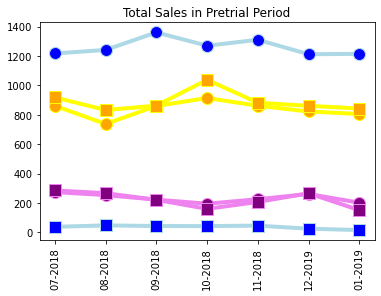

In [42]:
#  Trial Stores (o) and Control Stores (x)
months = ['07-2018', '08-2018', '09-2018', '10-2018', '11-2018', '12-2019', '01-2019']
plt.plot(months, pretrial77_sales, marker='o', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, pretrial233_sales, marker='s', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, pretrial86_sales, marker='o', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, pretrial114_sales, marker='s', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, pretrial88_sales, marker='o', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.plot(months, pretrial14_sales, marker='s', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.xticks(rotation=90)
plt.title('Total Sales in Pretrial Period')

Text(0.5, 1.0, 'Total Customers in Pretrial Period')

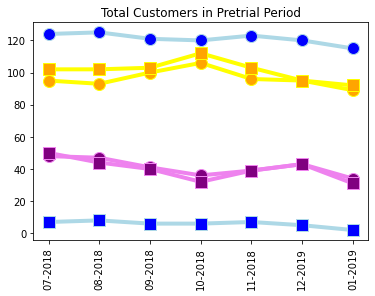

In [43]:
months = ['07-2018', '08-2018', '09-2018', '10-2018', '11-2018', '12-2019', '01-2019']
plt.plot(months, pretrial77_customers, marker='o', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, pretrial233_customers, marker='s', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, pretrial86_customers, marker='o', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, pretrial114_customers, marker='s', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, pretrial88_customers, marker='o', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.plot(months, pretrial14_customers, marker='s', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.xticks(rotation=90)
plt.title('Total Customers in Pretrial Period')

In [44]:
# Uplift Analysis

In [45]:
trial_233 = trial.loc[trial['STORE_NBR'] == 233]

trial77_sales = total_sales(trial_77)
trial233_sales = total_sales(trial_233)

trial77_customers = total_customers(trial_77)
trial233_customers = total_customers(trial_233)

trial77_transactions = avg_transactions(trial_77)
trial233_transactions = avg_transactions(trial_233)

trial_114 = trial.loc[trial['STORE_NBR'] == 114]

trial86_sales = total_sales(trial_86)
trial114_sales = total_sales(trial_114)

trial86_customers = total_customers(trial_86)
trial114_customers = total_customers(trial_114)

trial86_transactions = avg_transactions(trial_86)
trial114_transactions = avg_transactions(trial_114)

trial_14 = trial.loc[trial['STORE_NBR'] == 14]

trial88_sales = total_sales(trial_88)
trial14_sales = total_sales(trial_14)

trial88_customers = total_customers(trial_88)
trial14_customers = total_customers(trial_14)

trial88_transactions = avg_transactions(trial_88)
trial14_transactions = avg_transactions(trial_14)

pretrial77_transactions = avg_transactions(pretrial_77)
pretrial86_transactions = avg_transactions(pretrial_86)
pretrial88_transactions = avg_transactions(pretrial_88)

pretrial233_transactions = avg_transactions(pretrial_233)
pretrial114_transactions = avg_transactions(pretrial_114)
pretrial14_transactions = avg_transactions(pretrial_14)

In [46]:
diff_sales_77 = trial77_sales.mean() - pretrial77_sales.mean()
diff_sales_86 = trial86_sales.mean() - pretrial86_sales.mean()
diff_sales_88 = trial88_sales.mean() - pretrial88_sales.mean()

diff_sales_233 = trial233_sales.mean() - pretrial233_sales.mean()
diff_sales_114 = trial114_sales.mean() - pretrial114_sales.mean()
diff_sales_14 = trial14_sales.mean() - pretrial14_sales.mean()

diff_customers_77 = trial77_customers.mean() - pretrial77_customers.mean()
diff_customers_86 = trial86_customers.mean() - pretrial86_customers.mean()
diff_customers_88 = trial88_customers.mean() - pretrial88_customers.mean()

diff_customers_233 = trial233_customers.mean() - pretrial233_customers.mean()
diff_customers_114 = trial114_customers.mean() - pretrial114_customers.mean()
diff_customers_14 = trial14_customers.mean() - pretrial14_customers.mean()

diff_transactions_77 = trial77_transactions.mean() - pretrial77_transactions.mean()
diff_transactions_86 = trial86_transactions.mean() - pretrial86_transactions.mean()
diff_transactions_88 = trial88_transactions.mean() - pretrial88_transactions.mean()

diff_transactions_233 = trial233_transactions.mean() - pretrial233_transactions.mean()
diff_transactions_114 = trial114_transactions.mean() - pretrial114_transactions.mean()
diff_transactions_14 = trial14_transactions.mean() - pretrial14_transactions.mean()


diff_sales_trial = [diff_sales_77, diff_sales_86, diff_sales_88]
diff_sales_control = [diff_sales_233, diff_sales_114, diff_sales_14]
diff_customers_trial = [diff_customers_77, diff_customers_86, diff_customers_88]
diff_customers_control = [diff_customers_233, diff_customers_114, diff_customers_14]
diff_transactions_trial = [diff_transactions_77, diff_transactions_86, diff_transactions_88]
diff_transactions_control = [diff_transactions_233, diff_transactions_114, diff_transactions_14]

Text(0.5, 1.0, 'Total Sales in Trial Period')

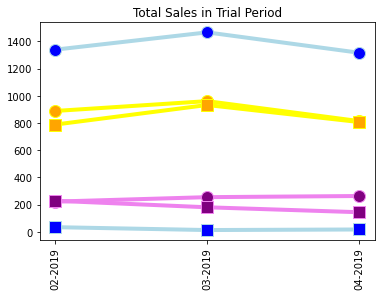

In [48]:
# Line Plots Demonstrating Divergence over Trial Period
months = ['02-2019', '03-2019', '04-2019']
plt.plot(months, trial77_sales, marker='o', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, trial233_sales, marker='s', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, trial86_sales, marker='o', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, trial114_sales, marker='s', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, trial88_sales, marker='o', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.plot(months, trial14_sales, marker='s', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.xticks(rotation=90)
plt.title('Total Sales in Trial Period')

Text(0.5, 1.0, 'Total Customers in Trial Period')

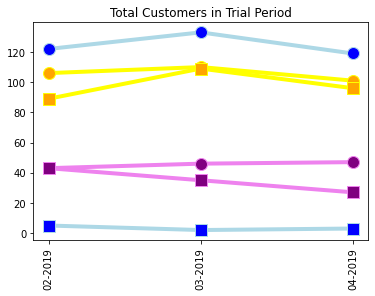

In [49]:
months = ['02-2019', '03-2019', '04-2019']
plt.plot(months, trial77_customers, marker='o', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, trial233_customers, marker='s', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, trial86_customers, marker='o', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, trial114_customers, marker='s', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, trial88_customers, marker='o', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.plot(months, trial14_customers, marker='s', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.xticks(rotation=90)
plt.title('Total Customers in Trial Period')

In [51]:
# One Tailed Independent Two Sample t-tests
from scipy import stats

In [52]:
sales_t = stats.ttest_ind(diff_sales_trial, diff_sales_control, equal_var=False)
customers_t = stats.ttest_ind(diff_customers_trial, diff_customers_control, equal_var=False)
transactions_t = stats.ttest_ind(diff_transactions_trial, diff_transactions_control, equal_var=False)

print('Total Sales Metric p-value: ', round(sales_t.pvalue/2, 3))
print('Total Sales Metric observed test statistic: ',  round(sales_t.statistic, 3))
print()
print('Total Customers Metric p-value: ', round(customers_t.pvalue/2, 3))
print('Total Customers Metric observed test statistic: ', round(customers_t.statistic, 3))
print()
print('Average Transactions Per Customer Metric p-value: ', round(transactions_t.pvalue/2, 3))
print('Average Transactions Per Customer Metric observed test statistic: ', round(transactions_t.statistic, 3))

Total Sales Metric p-value:  0.036
Total Sales Metric observed test statistic:  3.031

Total Customers Metric p-value:  0.013
Total Customers Metric observed test statistic:  4.686

Average Transactions Per Customer Metric p-value:  0.361
Average Transactions Per Customer Metric observed test statistic:  -0.405


In [53]:
# Plotting Distribution of Differences in Metrics over Trial and Control Stores

Text(0.5, 1.0, 'Total Sales')

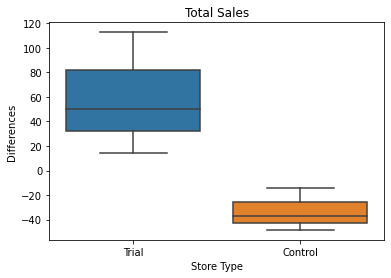

In [54]:
sales_diffs = {'Differences': [diff_sales_77, diff_sales_86, diff_sales_88, diff_sales_233, diff_sales_114, diff_sales_14], 'Store Type': ['Trial', 'Trial', 'Trial', 'Control', 'Control', 'Control']}
sales_diffs_df = pd.DataFrame(data=sales_diffs)
sns.boxplot(x='Store Type', y='Differences', data=sales_diffs_df)
plt.title('Total Sales')

Text(0.5, 1.0, 'Total Customers')

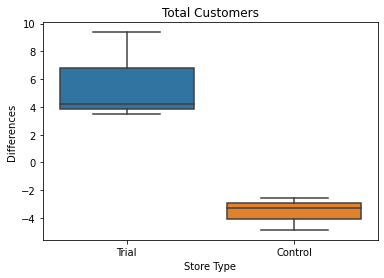

In [55]:
customers_diffs = {'Differences': [diff_customers_77, diff_customers_86, diff_customers_88, diff_customers_233, diff_customers_114, diff_customers_14], 'Store Type': ['Trial', 'Trial', 'Trial', 'Control', 'Control', 'Control']}
customers_diffs_df = pd.DataFrame(data=customers_diffs)
sns.boxplot(x='Store Type', y='Differences', data=customers_diffs_df)
plt.title('Total Customers')

Text(0.5, 1.0, 'Average Transactions Per Customer')

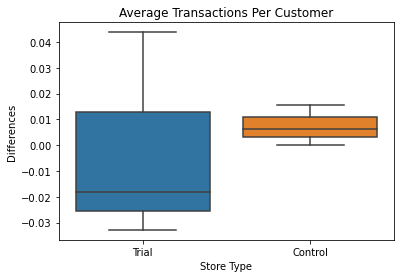

In [56]:
transactions_diffs = {'Differences': [diff_transactions_77, diff_transactions_86, diff_transactions_88, diff_transactions_233, diff_transactions_114, diff_transactions_14], 'Store Type': ['Trial', 'Trial', 'Trial', 'Control', 'Control', 'Control']}
transactions_diffs_df = pd.DataFrame(data=transactions_diffs)
sns.boxplot(x='Store Type', y='Differences', data=transactions_diffs_df)
plt.title('Average Transactions Per Customer')